In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from custom_trading_env import Actions,Positions,TradingEnv
from DQN_model import QNetwork

import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque


In [2]:
df_train = pd.read_csv('./data/TrainData.csv')
df_test = pd.read_csv('./data/TestData.csv')

# Feature Engineering
df_train['prev_high'] = df_train['high'].shift(1)
df_train['prev_close'] = df_train['close'].shift(1)
df_train['prev_low'] = df_train['low'].shift(1)
df_train['SMA_5'] = df_train['close'].rolling(window=5).mean().shift(1)
df_train['EMA_5'] = df_train['close'].ewm(span=5, adjust=False).mean().shift(1)
df_test['prev_high'] = df_test['high'].shift(1)
df_test['prev_close'] = df_test['close'].shift(1)
df_test['prev_low'] = df_test['low'].shift(1)
df_test['SMA_5'] = df_test['close'].rolling(window=5).mean().shift(1)
df_test['EMA_5'] = df_test['close'].ewm(span=5, adjust=False).mean().shift(1)

In [3]:
env = TradingEnv(df_train,5,(10,200))

189


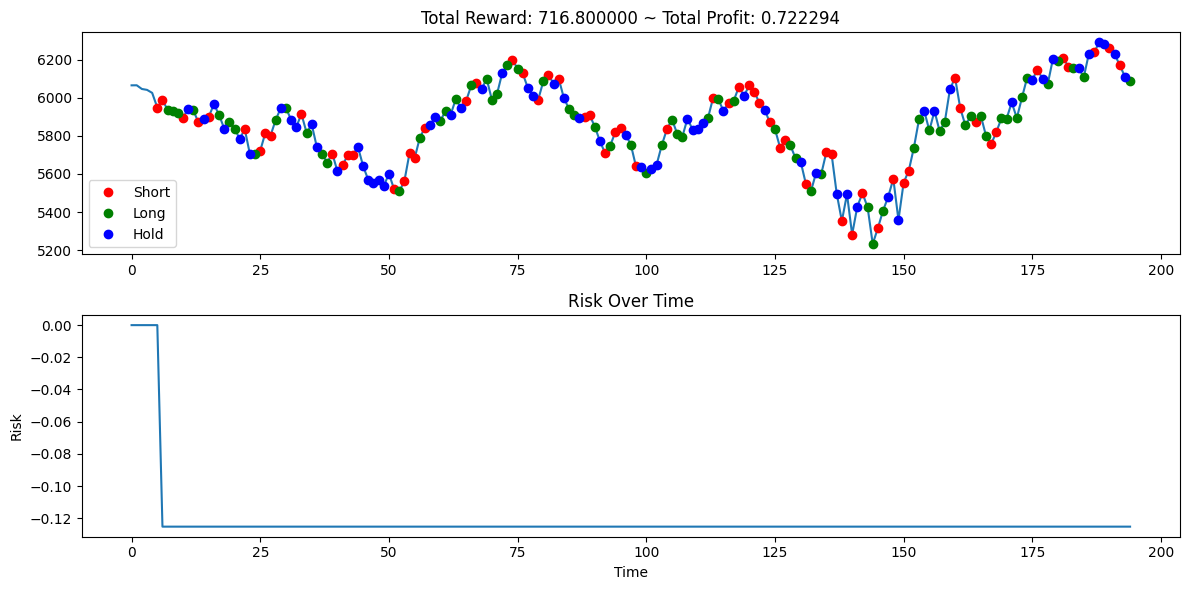

In [4]:
env.reset()
done=0
i=0
while not done:
    i+=1
    action = env.action_space.sample()
    # print(f"Action taken: {Actions(action).name}")  # Debug line
    obs,reward,done,info = env.step(action)
    # print(f"New position: {Positions(info['position']).name}")  # Debug line
    
    if done:
        print(i)
        env.render_all()


In [5]:
env.reset()
state_size = env.observation_space.shape[1]
action_size = env.action_space.n

q_network = QNetwork(state_size, action_size)
target_network = QNetwork(state_size, action_size)
optimizer = optim.Adam(q_network.parameters(), lr=0.001)

target_network.load_state_dict(q_network.state_dict())


<All keys matched successfully>

In [8]:

epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
gamma = 0.99

# Assuming q_network and target_network are already defined
# Assuming optimizer is already defined

memory = deque(maxlen=2000)

for episode in range(1000):
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Adding batch dimension
    
    for step in range(1000):
        # Epsilon-greedy action selection
        if random.random() <= epsilon:
            action = random.choice([0, 1, 2])
        else:
            with torch.no_grad():
                action = torch.argmax(q_network(state)).item()

        next_state, reward, done, _ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)  # Adding batch dimension
        
        memory.append((state, action, reward, next_state, done))
        
        if len(memory) > 32:
            # Randomly sample from memory
            batch = random.sample(memory, 32)
            state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
            
            state_batch = torch.stack(state_batch).squeeze(1)
            action_batch = torch.tensor(action_batch, dtype=torch.int64)
            reward_batch = torch.tensor(reward_batch, dtype=torch.float32)
            next_state_batch = torch.stack(next_state_batch).squeeze(1)
            done_batch = torch.tensor(done_batch, dtype=torch.float32)

            # Forward pass and loss computation
            current_q_values = q_network(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze()
            next_q_values = target_network(next_state_batch).max(1)[0]
            target_q_values = reward_batch + (gamma * next_q_values * (1 - done_batch))

            loss = nn.functional.mse_loss(current_q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update target network
            target_network.load_state_dict(q_network.state_dict())
        
        # Set the next state as the current state for the next iteration
        state = next_state

        if done:
            break
            
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

torch.save(q_network, './saved_models/model_2_200_days')



In [9]:
q_network  = torch.load('./saved_models/model_2_200_days')
q_network.eval()
env = TradingEnv(df_test,5,(10,1000))
env.reset()

# Initialize some variables to keep track of performance
total_rewards = 0
total_trades = 0
successful_trades = 0
episode_profits = []
# Number of episodes for testing
num_test_episodes = 100

for episode in range(num_test_episodes):
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Adding batch dimension
    episode_rewards = 0

    for step in range(1000):
        with torch.no_grad():
            action = torch.argmax(q_network(state)).item()

        next_state, reward, done, info = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)  # Adding batch dimension
        
        episode_rewards += reward
        episode_profit = env._total_profit
        episode_profits.append(episode_profit)

        # Optional: You can keep track of successful trades
        if reward > 0:
            successful_trades += 1

        total_trades += 1

        if done:
            break
        
        state = next_state

    print(f"Episode: {episode + 1}, Total Reward: {env._total_reward}, Total Profit: {episode_profit}")
    total_rewards += episode_rewards

print(f"Total rewards over {num_test_episodes} episodes: {total_rewards}")
print(f"Total trades made: {total_trades}")
print(f"Successful trades: {successful_trades}")
print(f"Success rate: {successful_trades/total_trades * 100:.2f}%")
average_profit = sum(episode_profits) / len(episode_profits)
print(f"Average Profit over {len(episode_profits)} episodes: {average_profit}")


Episode: 1, Total Reward: 0.0, Total Profit: 1.0
Episode: 2, Total Reward: 0.0, Total Profit: 1.0
Episode: 3, Total Reward: 0.0, Total Profit: 1.0
Episode: 4, Total Reward: 0.0, Total Profit: 1.0
Episode: 5, Total Reward: 0.0, Total Profit: 1.0
Episode: 6, Total Reward: 0.0, Total Profit: 1.0
Episode: 7, Total Reward: 0.0, Total Profit: 1.0
Episode: 8, Total Reward: 0.0, Total Profit: 1.0
Episode: 9, Total Reward: 0.0, Total Profit: 1.0
Episode: 10, Total Reward: 0.0, Total Profit: 1.0
Episode: 11, Total Reward: 0.0, Total Profit: 1.0
Episode: 12, Total Reward: 0.0, Total Profit: 1.0
Episode: 13, Total Reward: 0.0, Total Profit: 1.0
Episode: 14, Total Reward: 0.0, Total Profit: 1.0
Episode: 15, Total Reward: 0.0, Total Profit: 1.0
Episode: 16, Total Reward: 0.0, Total Profit: 1.0
Episode: 17, Total Reward: 0.0, Total Profit: 1.0
Episode: 18, Total Reward: 0.0, Total Profit: 1.0
Episode: 19, Total Reward: 0.0, Total Profit: 1.0
Episode: 20, Total Reward: 0.0, Total Profit: 1.0
Episode: 

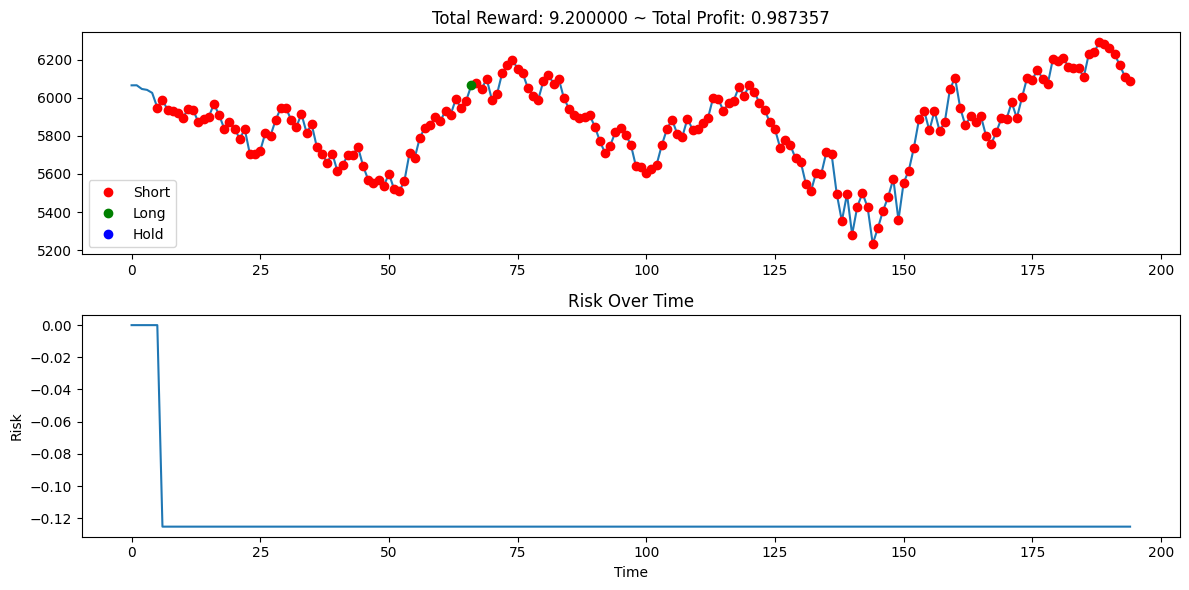

In [7]:
env.render_all()